# Library import

In [1]:
# Essentials packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rn

# Model selection - Split data to train set and test set
from sklearn.model_selection import train_test_split

# Keras Deep learning - Create neuro network model
from keras.models import Sequential
import keras.layers as layers

# Image processing tools for elastic distortion
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

Using TensorFlow backend.


# Dataset import

In this step, we import the Semeion dataset from our github repository - This is the same file found on UCI repository.

The dataset is also splitted in to train and test data with 80:20 split rule (80% data is for training, 20% is for testing). Here we use stratification to assure that the proportions of each digit classes in test and train sets are the similar.

In [0]:
# Open dataset
digits_url = "https://raw.githubusercontent.com/trangnguyenanhthuan/MachineLearningAsm2/master/semeion.data" # You can replace this line with local file's path if necessary
digits = pd.read_csv(digits_url, delimiter = " ", header = None)
digits.drop(columns=[266], inplace= True)
label_cols = [i + 256 for i in range (10)]

# Define X and Y
X = digits.drop(columns = label_cols)
Y = digits[label_cols]

# Split test and train
index,labels = np.where(Y.values == 1) # Stratification to make sure the each class has similar number of examples
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = labels, test_size=0.2, random_state=0) # Use a fixed random state

# Base model: K Nearest Neighbor

The base model is KNN model. Here, we use set the number of neighbors to 3 as it results in highest test accuracy

In [0]:
# Import KNN 
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Model with n_neighbor equals to 3
class KNNModel:
  def __init__(self):
    self.model = KNeighborsClassifier(n_neighbors=3)
  def fit(self, X_train, Y_train):
    self.model.fit(X_train, Y_train)
  def predict(self, X_predict):
    return self.model.predict(X_predict)
  def accuracy(self, X_test, Y_test):
    return self.model.score(X_test, Y_test)

In [4]:
# Create KNN model
knn_model = KNNModel()
knn_model.fit(X_train, Y_train)

# View performance
knn_score = knn_model.accuracy(X_test, Y_test)
print(f"The accuracy for KNN Model is: {knn_score}")

The accuracy for KNN Model is: 0.9059561128526645


# Support Vector Machine

Support Vector Machine is an algorithm to find a hyperplane which "best" seperate the training examples into their classes. It is arguably considered the most efficient out-of-the-box classifying algorithm by many. 

Here, the regularization constant is chosen to be 5 as its results in high test accuracy

In [0]:
# Support vector machine
from sklearn.svm import SVC

# Create SVM with C = 5 - C is the strength of the regularization
class SVCModel:
  def __init__(self):
    self.model = SVC(C=5)
  def fit(self, X_train, Y_train):
    self.model.fit(X_train, Y_train)
  def predict(self, X_predict):
    return self.model.predict(X_predict)
  def accuracy(self, X_test, Y_test):
    return self.model.score(X_test, Y_test)

In [6]:
# Get np array instead of dataframe
svc_X_train = X_train.values
svc_X_test = X_test.values

# Instead of using a dummy array -> We use label
svc_Y_test = np.argmax(Y_test.values, axis=1)
svc_Y_train = np.argmax(Y_train.values, axis=1)

# Fit
svc_model = SVCModel()
svc_model.fit(svc_X_train, svc_Y_train)

# Score
svc_score = svc_model.accuracy(svc_X_test, svc_Y_test)
print(f"The accuracy for SVC Model is {svc_score}")

The accuracy for SVC Model is 0.9686520376175548


## Linear Regression Classification

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Create Linear Regression Classification
class LRC:
  def predict_based(self,X_train,y_train,y):
      # Divide X_train by classes
      X_divided_by_class = []
      for i in range(10):
          X_divided_by_class.append(X_train[y_train == i].T)
      y_pre = []
      
      # Calculate y_hat
      for i in range(10):
          y_pre.append(LinearRegression().fit(X_divided_by_class[i],y).predict(X_divided_by_class[i]))
      
      # Deicide label based on the minimum distance
      label = np.zeros(10)
      for i in range(10):
          label[i] = np.sum(np.square(y - y_pre[i]))
      return np.argmin(label)

  def predict(self,X_train,y_train,Y):
      y_pre = []
      for i in range(len(Y)):
        y_pre.append(self.predict_based(X_train,y_train,Y.iloc[i].T))
      return y_pre

In [8]:
# Train model and print the accuracy (model achieve best result when test_size = 0.5)
lrc_X_train, lrc_X_test, lrc_Y_train, lrc_Y_test = train_test_split(X, labels,test_size = 0.2, stratify = labels, random_state = 0)
lrc_Y_predicted = LRC().predict(lrc_X_train, lrc_Y_train, lrc_X_test)

print("The accuracy of the Linear Regression Classification model:",accuracy_score(lrc_Y_test, lrc_Y_predicted))

The accuracy of the Linear Regression Classification model: 0.9310344827586207


# LeNet-5 Based Neural Network

![LeNet 5 architecture](https://miro.medium.com/max/1400/1*yG2c7PQQCRG0gL6ncfoQCg.png)


The architecture of this convolutional neural network is inspired by the approach taken by Yann LeCun for creating his LeNet-5 network. 

For the small dataset, we added the dropout layers with probability 0.3 after the max pooling layers to alleviate the effects of overfitting

In [0]:
# Create neuro network model with LeNet 5 architecture
class LeNet5:
  def __init__(self):
    # Create CNN Model
    model = Sequential()

    # Convolution -> Average Pooling
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))

    # Convolution -> Average Pooling
    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))

    # Flatten into array
    model.add(layers.Flatten())

    # First dense layer
    model.add(layers.Dense(units=120, activation='relu'))

    # Second dense layer
    model.add(layers.Dense(units=84, activation='relu'))

    # Result layer
    model.add(layers.Dense(units=10, activation = 'softmax'))

    # Compile model
    model.compile(optimizer="adam", metrics=["accuracy"], loss="categorical_crossentropy")

    # Assign to instance
    self.model = model

  def fit(self, X_train, Y_train, epochs=150, batch_size=5):
      self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

  def predict(self, X_predict):
    return self.model.predict(X_predict)

  def accuracy(self, X_test, Y_test):
    _, accuracy = self.model.evaluate(X_test, Y_test)
    return accuracy

## a) Without elastic distortion

In [10]:
# Make sure that we add the chanel layer, in this case 1
lenet_X_train = X_train.values.reshape([-1, 16, 16, 1])
lenet_X_test = X_test.values.reshape([-1, 16, 16, 1])

# Add padding to create a (32, 32, 1) image
lenet_X_train = np.pad(lenet_X_train, ((0, 0), (8, 8), (8, 8), (0, 0)))
lenet_X_test = np.pad(lenet_X_test, ((0, 0), (8, 8), (8, 8), (0, 0)))

# Fit
lenet_model = LeNet5()
lenet_model.fit(lenet_X_train, Y_train, epochs=150, batch_size=5)

# Score
score = lenet_model.accuracy(lenet_X_test, Y_test)
print(f"The accuracy of the LeNet5 model (without elastic distortion) is {score}")

Epoch 1/150
1274/1274 [==============================] - 2s 1ms/step - loss: 1.4181 - accuracy: 0.5031
Epoch 2/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.4735 - accuracy: 0.8540
Epoch 3/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.3031 - accuracy: 0.9027
Epoch 4/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.2399 - accuracy: 0.9231
Epoch 5/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.2137 - accuracy: 0.9270
Epoch 6/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.1849 - accuracy: 0.9380
Epoch 7/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.1663 - accuracy: 0.9490
Epoch 8/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.1392 - accuracy: 0.9521
Epoch 9/150
1274/1274 [==============================] - 1s 1ms/step - loss: 0.1150 - accuracy: 0.9560
Epoch 10/150
1274/1274 [==============================] - 1s 1ms/step - l

## b) With Elastic Distortion

One of the common data augmentation method for CNN is affine distortion and elastic distortion. The latter was proposed by Simard in his influencial paper in 2003.  Here, the elastic_transform function is implemented based on his research to generate more training data.

In [0]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """
    Elastic Distortion function implemented based on Simard's paper
    image: the image that requires distortion
    alpha: the 'strength' of the distortion
    sigma: the standard deviation of the Gaussian Convolutional Filter
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    image_shape = image.shape
    dx = alpha * gaussian_filter((random_state.rand(*image_shape) * 2 - 1), sigma, mode="constant", cval=0)
    dy = alpha * gaussian_filter((random_state.rand(*image_shape) * 2 - 1), sigma, mode="constant", cval=0)
    dz = np.zeros(dx.shape)

    x, y, z = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), np.arange(image_shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image_shape)

def generate_elastic_distortion(images, classes, alpha, sigma, image_width = 16, image_height = 16, per_image=5):
    """
    Function to create bulk agmentation
    Parameters:
    - images: An array with the shape of (number_of_images, image_width x image_height)
    - image_width: The width of each image
    - alpha: The degree (magnitude) of transformation
    - sigma: The standard deviation of the Convolution Gaussian kernel
    - image_height: The height of each image
    - per_image: How many disorted image to generate for each image
    """
    # Intialize an array
    new_dataset = np.zeros([1, 266])
    
    # Generate elastic distorion for images
    for i in range(images.shape[0]):
        # Image now has the shape (image_width x image_height) -> Reshape
        image = images[i, :].reshape([image_width, image_height, 1]) # The number of channel is 1
        result = classes[i, :]

        for _ in range(per_image):
            # Generate distorted image using elastic_transform
            distorted_image = elastic_transform(image, alpha, sigma)
            distorted_image = distorted_image.reshape([image_width * image_height])
            combined = np.concatenate((distorted_image, result))
            
            # Push to array
            new_dataset = np.append(new_dataset, combined.reshape(1, -1), axis=0)

    return np.delete(new_dataset, 0, axis=0)

In [0]:
# Generate Elastic Distortion of images
# We generate 3 new distorted images per original image and then create a new dataset
new_dataset = generate_elastic_distortion(X_train.values, Y_train.values, alpha=300, sigma=4, per_image=3)
lenet_X_train = new_dataset[:, :256]
lenet_Y_train = new_dataset[:, 256:]

# Make sure that we add the chanel layer, in this case 1
lenet_X_train = lenet_X_train.reshape([-1, 16, 16, 1])
lenet_X_test = X_test.values.reshape([-1, 16, 16, 1])

# Add padding to create a (32, 32, 1) image
lenet_X_train = np.pad(lenet_X_train, ((0, 0), (8, 8), (8, 8), (0, 0)))
lenet_X_test = np.pad(lenet_X_test, ((0, 0), (8, 8), (8, 8), (0, 0)))

We then train the LeNet model on these newly generated data

In [16]:
# Fit
lenet_model = LeNet5()
lenet_model.fit(lenet_X_train, lenet_Y_train, epochs=50, batch_size=5)

# Score
score = lenet_model.accuracy(lenet_X_test, Y_test)
print(f"The score of the LeNet5 model (with elastic distortion) is {score}")

Epoch 1/50
3822/3822 [==============================] - 4s 1ms/step - loss: 1.0562 - accuracy: 0.6418
Epoch 2/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.4631 - accuracy: 0.8443
Epoch 3/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.3690 - accuracy: 0.8731
Epoch 4/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.3264 - accuracy: 0.8906
Epoch 5/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.2759 - accuracy: 0.9076
Epoch 6/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.2609 - accuracy: 0.9079
Epoch 7/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.2309 - accuracy: 0.9283
Epoch 8/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.2012 - accuracy: 0.9351
Epoch 9/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.1892 - accuracy: 0.9401
Epoch 10/50
3822/3822 [==============================] - 4s 1ms/step - loss: 0.182

# Hybrid Convolutional Neural Network With SVM

![Hybrid Convolutional Neural Network With SVM](https://raw.githubusercontent.com/trangnguyenanhthuan/MachineLearningAsm2/master/img.jpg)

Bellow is the implementation of a modified hybrid CNN-SVM model. While the CNN uses the training data for feature extraction, the SVM then makes use of these extracted features to train.

In [0]:
# Import Model to extract features from keras model
from keras.models import Model
# Import SVC to classify extracted features
from sklearn.svm import SVC

# Create neuro network model with Hybrid Convolutional Neural Network With SVM - we add Dropout layers
class HybridSVM:
  def __init__(self):
    # Initialize a neural network for feature extraction
    model = Sequential()

    # Convolution -> Average Pooling
    model.add(layers.Conv2D(filters=25, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))
    
    # Convolution -> Average Pooling
    model.add(layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))

    # Flatten
    model.add(layers.Flatten())

    # First dense layer
    model.add(layers.Dense(units=100, activation='relu'))
    # Result layer
    model.add(layers.Dense(units=10, activation = 'softmax'))

    # Compile model
    model.compile(optimizer="adam", metrics=["accuracy"], loss="categorical_crossentropy")

    # Assign model to instance
    self.neural_net = model

    # Build an intermediate model to get the dense layer output
    self.intermediate_model = Model(inputs=self.neural_net.input, outputs=self.neural_net.layers[7].output)

    # Create a SVC model
    self.svc = SVC()

  def fit(self, X_train, Y_train):
    # First we train the neural net to extract features from data
    self.neural_net.fit(X_train, Y_train, epochs=100, batch_size=5)

    # Pass to SVM to train
    svc_x_train = self.intermediate_model.predict(X_train)
    svc_y_train = np.argmax(Y_train.values, axis=1)

    # Fit the SVM
    self.svc.fit(svc_x_train, svc_y_train)

  def predict(self, X_test):
    # First feed it through neural net
    X_intermediate = self.intermediate_model.predict(X_test)
    # Then we use svm to predict
    X_predicted = self.svc.predict(X_intermediate)
    # Return predicted
    return X_predicted
  
  def accuracy(self, X_test, Y_test):
    # Get the intermediate model result
    svc_x_test = self.intermediate_model.predict(X_test)

    # Map dummy array to label
    svc_y_test = np.argmax(Y_test.values, axis=1)

    # Get the SVC score
    return self.svc.score(svc_x_test, svc_y_test)

In [18]:
# Make sure that we add the chanel layer, in this case 1
hybrid_X_train = X_train.values.reshape([-1, 16, 16, 1])
hybrid_X_test = X_test.values.reshape([-1, 16, 16, 1])

# Add padding to create a (32, 32, 1) image
hybrid_X_train = np.pad(hybrid_X_train, ((0, 0), (6, 6), (6, 6), (0, 0)))
hybrid_X_test = np.pad(hybrid_X_test, ((0, 0), (6, 6), (6, 6), (0, 0)))

# Fit
hybrid_model = HybridSVM()
hybrid_model.fit(hybrid_X_train, Y_train)

# Score
print(f"The accuracy for the Hybrid model is {hybrid_model.accuracy(hybrid_X_test, Y_test)}")

Epoch 1/100
1274/1274 [==============================] - 2s 2ms/step - loss: 1.3863 - accuracy: 0.5251
Epoch 2/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.4249 - accuracy: 0.8579
Epoch 3/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.3040 - accuracy: 0.9105
Epoch 4/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.1917 - accuracy: 0.9372
Epoch 5/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.1745 - accuracy: 0.9419
Epoch 6/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.1522 - accuracy: 0.9451
Epoch 7/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.0934 - accuracy: 0.9686
Epoch 8/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.1179 - accuracy: 0.9568
Epoch 9/100
1274/1274 [==============================] - 2s 2ms/step - loss: 0.0904 - accuracy: 0.9655
Epoch 10/100
1274/1274 [==============================] - 2s 2ms/step - l

# Independence Evaluation

The independent evaluation dataset is created by writing the number on a paper sheet, cutting them using a image processing program and then scalling them to get 16x16 pixel binary images.

The images are then flatten into 256-element arrays and then unified to form a numpy array which is saved as created.data.

In [0]:
# Open dataset
test_digits_url = "https://raw.githubusercontent.com/PhatTranSon/MachineLearningAssignment/master/independent.data"
test_digits = pd.read_csv(test_digits_url, delimiter = " ", header = None)

# Define X and Y
independent_X = test_digits.iloc[:, :256].values
independent_Y = test_digits.iloc[:, 256:]

In [20]:
# Reshape the input
hybrid_X = independent_X.reshape([-1, 16, 16, 1])
hybrid_X = np.pad(hybrid_X, ((0, 0), (6, 6), (6, 6), (0, 0)))
# Fit the model
hybrid_score = hybrid_model.accuracy(hybrid_X, independent_Y)
# Print score
print(f"The independent evaluation accuracy for hybrid model is {hybrid_score}")

The independent evaluation accuracy for hybrid model is 0.7916666666666666


In [22]:
# Reshape the input
lenet_X = independent_X.reshape([-1, 16, 16, 1])
lenet_X = np.pad(lenet_X, ((0, 0), (8, 8), (8, 8), (0, 0)))

# Fit the model
lenet_score = lenet_model.accuracy(lenet_X, independent_Y)

# Print score
print(f"The independent evaluation accuracy for LeNet model is {lenet_score}")

312/312 [==============================] - 0s 309us/step
The independent evaluation accuracy for LeNet model is 0.7788461446762085


In [23]:
# KNN model
knn_score = knn_model.accuracy(independent_X, independent_Y)
print(f"The independent evaluation accuracy for KNN model is {knn_score}")

The independent evaluation accuracy for KNN model is 0.46794871794871795


In [24]:
# SVC model
svc_independent_X = independent_X
svc_independent_Y = np.argmax(independent_Y.values, axis=1)

svc_score = svc_model.accuracy(svc_independent_X, svc_independent_Y)
print(f"The independent evaluation accuracy for SVM model is {svc_score}")

The independent evaluation accuracy for SVM model is 0.47435897435897434


In [26]:
# Define X and Y
lrc_independent_X = test_digits.iloc[:, :256]
lrc_independent_Y_ = test_digits.iloc[:, 256:]
index, lrc_independent_y = index,labels = np.where(independent_Y.values == 1)
lrc_y_pre = LRC().predict(lrc_X_train, lrc_Y_train, lrc_independent_X)

print("The accuracy of the Linear Regression Classification model on independent dataset:",accuracy_score(lrc_independent_y, lrc_y_pre))

The accuracy of the Linear Regression Classification model on independent dataset: 0.5865384615384616


# Inaccurate prediction analysis

In this section, we view the images that were inaccurately classfied by two top models: LeNet inspired and Hybrid CNN-SVM

## a) LeNet-inspired model

In [0]:
# Predict test set
lenet_predicted_Y = np.argmax(lenet_model.predict(lenet_X_test), axis=1)
lenet_actual_Y = np.argmax(Y_test.values, axis=1)

# Get the wrong position
lenet_wrong_positions = np.nonzero(lenet_predicted_Y != lenet_actual_Y)[0]

# Get the wrong digits
lenet_Y_actual_label = lenet_actual_Y[lenet_wrong_positions]
lenet_Y_predicted_label = lenet_predicted_Y[lenet_wrong_positions]

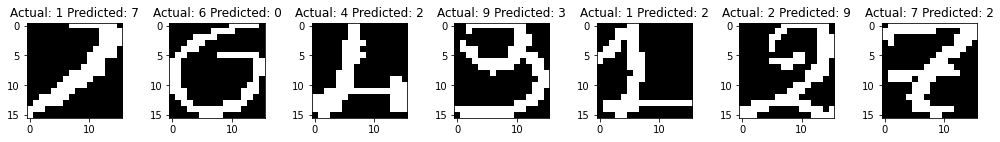

In [28]:
# Plot
num_row = 1
num_col = lenet_wrong_positions.shape[0]

# Create figure
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(num_col):
    ax = axes[i]
    ax.imshow(X_test.values[lenet_wrong_positions[i], :].reshape(16, 16), cmap='gray')
    ax.set_title('Actual: {} Predicted: {}'.format(lenet_Y_actual_label[i], lenet_Y_predicted_label[i]))

# Show 
plt.tight_layout()
plt.savefig("lenet_wrong2.png")
plt.show()

## b) Hyrbid model

In [0]:
# Get predictions
hybrid_predicted_Y = hybrid_model.predict(hybrid_X_test)
hybrid_actual_Y = np.argmax(Y_test.values, axis=1)

# Get the wrong position
hybrid_wrong_positions = np.nonzero(hybrid_predicted_Y != hybrid_actual_Y)[0]

# Get the wrong digits
hybrid_X_wrong = X_test.values[hybrid_wrong_positions, :]
hybrid_Y_actual_label = hybrid_actual_Y[hybrid_wrong_positions]
hybrid_Y_predicted_label = hybrid_predicted_Y[hybrid_wrong_positions]

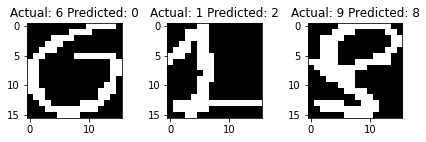

In [30]:
# Plot
num_row = 1
num_col = hybrid_wrong_positions.shape[0]

# Create figure
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(num_col):
    ax = axes[i]
    ax.imshow(X_test.values[hybrid_wrong_positions[i], :].reshape(16, 16), cmap='gray')
    ax.set_title('Actual: {} Predicted: {}'.format(hybrid_Y_actual_label[i], hybrid_Y_predicted_label[i]))

# Show 
plt.tight_layout()
plt.savefig("hybrid_wrong.png")
plt.show()

# Transfer Learning on Independent Set

In this approach, we train the CNN using training data, freeze its weights and proceed to train the SVM classifier using train data from the independent set.

In [0]:
class HybridSVMTransferV2:
  def __init__(self, pretrained):
    # Set the pre trained model
    self.pretrained_model = pretrained

  def fit(self, X_train, Y_train):
    # We freeze the CNN weights -> We fit only the SVM classifier
    svc_x_train = self.pretrained_model.intermediate_model.predict(X_train)
    svc_y_train = np.argmax(Y_train.values, axis=1)
    self.pretrained_model.svc.fit(svc_x_train, svc_y_train)

  def accuracy(self, X_test, Y_test):
    # Get the intermediate model result
    svc_x_test = self.pretrained_model.intermediate_model.predict(X_test)
    # Map dummy array to label
    svc_y_test = np.argmax(Y_test.values, axis=1)
    # Get the SVC score
    return self.pretrained_model.svc.score(svc_x_test, svc_y_test)

In [32]:
# Split train and test set for independent set
index, labels = np.where(independent_Y.values == 1)
independent_X_train, independent_X_test, independent_Y_train, independent_Y_test = train_test_split(independent_X, independent_Y, stratify = labels, test_size=0.2, random_state=0)

# Add padding
# Make sure that we add the chanel layer, in this case 1
target_X_train = independent_X_train.reshape([-1, 16, 16, 1])
target_X_test = independent_X_test.reshape([-1, 16, 16, 1])

# Add padding to create a (32, 32, 1) image
target_X_train = np.pad(target_X_train, ((0, 0), (6, 6), (6, 6), (0, 0)))
target_X_test = np.pad(target_X_test, ((0, 0), (6, 6), (6, 6), (0, 0)))

# Create model and train
transfer_model = HybridSVMTransferV2(hybrid_model)
transfer_model.fit(target_X_train, independent_Y_train)

# Display accuracy
print(f"The accuracy of Transfer Learning model is {transfer_model.accuracy(target_X_test, independent_Y_test)}")

The accuracy of Transfer Learning model is 0.9523809523809523
